In [ ]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp
import importlib
import healpy

from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params, configure_plot_params

configure_plot_params(fontsize=12)

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params

# exposure = 5 * 14000 / (4 * np.pi)
# p = update_params(param_file, p, 'exposure', exposure)

# phipp = 7.12073e-30
# fwimp = phipp * 8 * np.pi / 1e-28
# # fwimp = 1e-4
# p = update_params(param_file, p, 'fwimp', fwimp)

# p = update_params(param_file, p, 'bg', 1)
# p = update_params(param_file, p, 'beg', 1)

# print(exposure, fwimp)
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.1,
 'M_max': 10000000000.0,
 'fwimp': 1.78,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -16,
 'log_flux_max': -2,
 'N': 2200,
 'log_k_min': -2,
 'log_k_max': 10,
 'N_k': 250000,
 'psh_log_f_min': -7,
 'psh_log_f_max': -1.0,
 'N_psh': 1000,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5570.423008216337,
 'iso_flux_bg': 0.0008615905978150363,
 'gal_flux_bg_file': './output/gal_flux_bg.npy',
 'bg': 1,
 'beg': 1,
 'beta': 1.9}

In [4]:
nside = p['nside']
npix = healpy.nside2npix(nside)
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
good_indices = (abs(lat) >= 40)

In [5]:
## S-WAVE
s_psh, s_pshfunc2d, s_fluxes, _ = pd.psh_s(ang_dists[good_indices], input_file='./output/n0_pshfunc_paper.npz', return_all=True)
s_psh = s_psh[::3]
s_fluxes = s_fluxes[::3]

## SOM
som_fwimp_rescale = 10.6404808663
som_psh, som_pshfunc2d, som_fluxes, _= pd.psh_som(ang_dists[good_indices], input_file='./output/n-1_pshfunc_paper.npz', return_all=True, rescale=som_fwimp_rescale)
som_psh = som_psh[::3]
som_fluxes = som_fluxes[::3]

# som_psh /= som_fwimp_rescale
# som_fluxes *= som_fwimp_rescale

# print(s_fluxes, som_fluxes)

In [6]:
# search parameters
num_search = 80
p['fwimp'] *= 1

fwimps = np.logspace(np.log10(p['fwimp'])-.75, np.log10(p['fwimp'])+.75, num_search)
begs = np.linspace(.925, 1.075, num=num_search)

exposure_search = np.logspace(0, 1, num=1) * p['exposure']
exposure_search = np.array([1]) * p['exposure']

In [7]:
 def likelihood_run_for_model_2d(p, psh, fluxes, poisson_rescale=1, model='', som_fwimp_rescale=1, s_fwimp_rescale=1, bgd_overmodel=1, bgd_undermodel=1, load_data_file=None):
    # run likelihoods
    s_S = np.zeros((len(exposure_search), len(begs), num_search))
    som_S = np.zeros((len(exposure_search), len(begs), num_search))
    poisson_S = np.zeros((len(exposure_search), len(begs), num_search))

    for i, exposure in enumerate(exposure_search):
        p['exposure'] = exposure

        gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure'] * p['bg']
        iso_bg = p['iso_flux_bg'] * p['exposure'] * p['beg']
#         bg_count = gal_bg * 0.97 + iso_bg
        bg_count = gal_bg * bgd_overmodel + iso_bg

        counts = np.arange(0, bg_count.max() + 4 * np.sqrt(bg_count.max()) + p['exposure'] * p['fwimp'] * fluxes.max())

        print('calculating pc to count =', counts[-1])

        unique_ang, uni_ind, uni_inv = np.unique(np.abs(ang_dists[good_indices]), return_inverse=True, return_index=True)
        
        print('psh mean', np.trapz(fluxes * psh[:, 0], fluxes))

        pshdat = psh[:, uni_ind]
        psh = pshdat[:, uni_inv]
        if model == 's':
            spsh = pshdat[:, uni_inv]
            sompsh = som_psh
        elif model == 'som':
            sompsh = pshdat[:, uni_inv]
            spsh = s_psh
        else:
            spsh = s_psh
            sompsh = som_psh

        if load_data_file is None:
            if model == '':
                pc_psi = stats.poisson.pmf(counts[np.newaxis, :], np.trapz(psh * fluxes[:, np.newaxis] * p['exposure'] * p['fwimp'], fluxes[:, np.newaxis], axis=0)[:, np.newaxis])
            else:
                pc_psi = integrate.simps(pshdat[..., np.newaxis] * stats.poisson.pmf(counts[np.newaxis, np.newaxis, :], p['exposure'] * p['fwimp'] * fluxes[:, np.newaxis, np.newaxis]), fluxes, axis=0)
                pc_psi /= np.sum(pc_psi, axis=-1)[:, np.newaxis]

            print('is pc norm', np.allclose(np.sum(pc_psi, axis=-1), 1))
            print('last pc prob', pc_psi[:, -1])

            pc_of_psi = pc_psi[uni_inv]

            # generate sky map
            subcounts = pd.generate_skymap_sample_pc(p, pc_of_psi, ang_dists[good_indices], good_indices, return_subcounts=True, save_output=True, bg_counts=bg_count)

            print('generated skymap with', p['fwimp'])
            print('max counts', counts[-1], subcounts.max())
        else:
            subcounts = np.load(load_data_file)[good_indices]
            print('loaded skymap from', load_data_file)
            print('max counts', counts[-1], subcounts.max())
            
        for j, beg in enumerate(begs):
            for k, fwimp in enumerate(fwimps):
#                 S = pd.likelihood2d([exposure, beg, fwimp * s_fwimp_rescale], spsh, subcounts.astype(np.int16), s_fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg)
                S = pd.likelihood2d([exposure, beg, fwimp * s_fwimp_rescale], spsh, subcounts.astype(np.int16), s_fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg*bgd_undermodel)
                s_S[i, j, k] = S

#                 S = pd.likelihood2d([exposure, beg, fwimp * som_fwimp_rescale], sompsh, subcounts.astype(np.int16), som_fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg)
                S = pd.likelihood2d([exposure, beg, fwimp * som_fwimp_rescale], sompsh, subcounts.astype(np.int16), som_fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg*bgd_undermodel)
                som_S[i, j, k] = S

#                 S = pd.poisson_likelihood2d([exposure, beg, fwimp/poisson_rescale], psh, subcounts.astype(np.int16), fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg)
                S = pd.poisson_likelihood2d([exposure, beg, fwimp/poisson_rescale], psh, subcounts.astype(np.int16), fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg*bgd_undermodel)
                poisson_S[i, j, k] = S
#                 if k % 20 == 0:
#                     print('k', k, '/', 100)
            if j % 10 == 0:
                print(j, '/', len(begs))
        print(i+1, '/', len(exposure_search))
        
#     from scipy.optimize import minimize
    
#     indmax = np.unravel_index(np.argmin(s_S, axis=None), s_S.shape)
    
#     s_max = minimize(pd.likelihood2d, [exposure_search[indmax[0]], begs[indmax[1]], fwimps[indmax[2]]], args=(spsh, subcounts.astype(np.int16), s_fluxes, iso_bg, gal_bg), method='Nelder-Mead')
#     print('swave\t', s_max)
    
#     som_max = minimize(pd.likelihood2d, [exposure_search[indmax[0]], begs[indmax[1]], fwimps[indmax[2]]/100], args=(sompsh, subcounts.astype(np.int16), som_fluxes, iso_bg, gal_bg), method='Nelder-Mead')
#     print('som\t', som_max)
    
#     poi_max = minimize(pd.likelihood2d, [exposure_search[indmax[0]], begs[indmax[1]], fwimps[indmax[2]]/poisson_rescale], args=(psh, subcounts.astype(np.int16), fluxes, iso_bg, gal_bg), method='Nelder-Mead')
#     print('poi\t', poi_max)
    
    return [s_S, som_S, poisson_S]

In [8]:
s_file = './output/nNull_skymap_48061.npy'
som_file = './output/n-1_skymap_90168.npy'
poi_file = './output/nNull_skymap_36658.npy'
# s_file = None
# som_file = None
# poi_file = None

In [9]:
SS = [[],[],[]]

# import pickle
# with open('./output/param_scan.pickle', 'rb') as infile:
#     SS = pickle.load(infile)

p['n'] = 0
SS[0] = likelihood_run_for_model_2d(p, s_psh, s_fluxes, model='s', load_data_file=s_file)

fwimp_orig = p['fwimp']
# p['fwimp'] *= som_fwimp_rescale
# fwimps *= som_fwimp_rescale

p['n'] = -1
SS[1] = likelihood_run_for_model_2d(p, som_psh, som_fluxes, model='som', load_data_file=som_file)

# p['fwimp'] /= 1e100
# fwimps /= som_fwimp_rescale

p['n'] = 'Null'
SS[2] = likelihood_run_for_model_2d(p, som_psh, som_fluxes, model='', load_data_file=poi_file)

# p['fwimp'] = fwimp_orig

import pickle
with open('./output/param_scan.pickle', 'wb') as outfile:
    pickle.dump(SS, outfile)

calculating pc to count = 98.0
psh mean 6.874653864048926e-05
loaded skymap from ./output/nNull_skymap_48061.npy
max counts 98.0 56.0
0 / 80
10 / 80
20 / 80
30 / 80
40 / 80
50 / 80
60 / 80
70 / 80
1 / 1
calculating pc to count = 95.0
psh mean 8.412409206005941e-05
loaded skymap from ./output/n-1_skymap_90168.npy
max counts 95.0 63.0
0 / 80
10 / 80
20 / 80
30 / 80
40 / 80
50 / 80
60 / 80
70 / 80
1 / 1
calculating pc to count = 95.0
psh mean 8.412409206005941e-05
loaded skymap from ./output/nNull_skymap_36658.npy
max counts 95.0 60.0
0 / 80
10 / 80
20 / 80
30 / 80
40 / 80
50 / 80
60 / 80
70 / 80
1 / 1


In [10]:
import pickle
with open('./output/param_scan.pickle', 'rb') as infile:
    SS = pickle.load(infile)
    

[185742.9899576823, 185745.9899576823]
[ 0.   0.5  2.   4.5  8.  12.5]
[185842.44245752846, 185845.44245752846]
[ 0.   0.5  2.   4.5  8.  12.5]
[185791.7508556719, 185794.7508556719]
[ 0.   0.5  2.   4.5  8.  12.5]
[184922.21246641627, 184925.21246641627]
[ 0.   0.5  2.   4.5  8.  12.5]
[184935.87037200405, 184938.87037200405]
[ 0.   0.5  2.   4.5  8.  12.5]
[184920.29845812262, 184923.29845812262]
[ 0.   0.5  2.   4.5  8.  12.5]
[185501.25565963011, 185504.25565963011]
[ 0.   0.5  2.   4.5  8.  12.5]
[185541.17899420852, 185544.17899420852]
[ 0.   0.5  2.   4.5  8.  12.5]
[185483.01707247604, 185486.01707247604]
[ 0.   0.5  2.   4.5  8.  12.5]
1.78


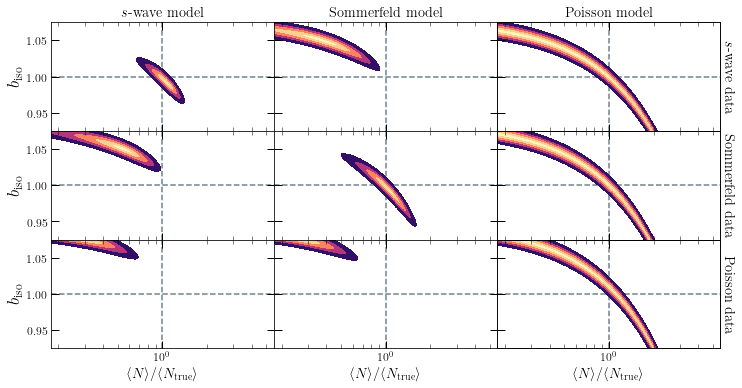

In [11]:
fig, axss = plt.subplots(ncols=3, nrows=3, figsize=(12, 6), sharey=True, sharex=True, gridspec_kw={'wspace': 0, 'hspace': 0})
i = 0
lw = 5
zorder = 1

from matplotlib import cm
cmap = cm.magma_r
axs = axss[0]
levels = [0, 1/2, 4/2, 9/2, 16/2, 25/2]

for i in range(3):
    for ax, s, lab in zip(axss[i], SS[i], ['s-wave L', 'som L', 'poisson L']):
        colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
        
        for expdat, expo in zip(s, exposure_search):
            indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
#             ax.contourf(fwimps / p['fwimp'], begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
            con = ax.contourf(fwimps / p['fwimp'], begs, (0.5*(expdat - expdat.min())), cmap=cmap, levels=levels)
            print([0.5 * expdat.min() - 4, 0.5 * expdat.min() - 1])
            print(con.levels)
            ax.axvline(p['fwimp'] / p['fwimp'], ls='--', color='xkcd:steel gray', zorder=-100)
            ax.axhline(1, ls='--', color='xkcd:steel gray', zorder=-100)
#             ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)

        ax.set_xscale('log')

for ax in axss[-1]:
#     ax.set_xlabel(r'$f_\mathrm{WIMP}$', fontsize='large')
#     ax.set_xlabel(r'$\Phi_\mathrm{PP}$', fontsize='large')
    ax.set_xlabel(r'$\langle N\rangle/\langle N_\mathrm{true}\rangle$', fontsize='large')
    
axss[0, 0].set_ylabel(r'$b_\mathrm{iso}$', fontsize='x-large')
axss[1, 0].set_ylabel(r'$b_\mathrm{iso}$', fontsize='x-large')
axss[2, 0].set_ylabel(r'$b_\mathrm{iso}$', fontsize='x-large')

ax = axss[0, -1].twinx()
ax.set_ylabel('$s$-wave data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

ax = axss[1, -1].twinx()
ax.set_ylabel('Sommerfeld data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

ax = axss[2, -1].twinx()
ax.set_ylabel('Poisson data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

axss[0, 0].set_title(r'$s$-wave model')
axss[0, 1].set_title('Sommerfeld model')
axss[0, 2].set_title('Poisson model')
    
# axss.flatten()[-1].legend()
#     ax.set_yscale('log')
#     ax.set_ylim(bottom=0, top=10)
print(p['fwimp'])
fig.savefig('./output/plots/llhds_2d_fermiexposure.pdf')

In [12]:
SS = [[],[],[]]

# import pickle
# with open('./output/param_scan.pickle', 'rb') as infile:
#     SS = pickle.load(infile)

p['n'] = 0
SS[0] = likelihood_run_for_model_2d(p, s_psh, s_fluxes, model='s', bgd_undermodel=1.03, load_data_file=s_file)
fwimp_orig = p['fwimp']
# p['fwimp'] *= som_fwimp_rescale
# fwimps *= som_fwimp_rescale

p['n'] = -1
SS[1] = likelihood_run_for_model_2d(p, som_psh, som_fluxes, model='som', bgd_undermodel=1.03, load_data_file=som_file)

# p['fwimp'] /= 1e100
# fwimps /= som_fwimp_rescale

p['n'] = 'Null'
SS[2] = likelihood_run_for_model_2d(p, som_psh, som_fluxes, model='', bgd_undermodel=1.03, load_data_file=poi_file)

# p['fwimp'] = fwimp_orig

import pickle
with open('./output/param_scan_bgd_overmodel.pickle', 'wb') as outfile:
    pickle.dump(SS, outfile)

calculating pc to count = 98.0
psh mean 6.874653864048926e-05
loaded skymap from ./output/nNull_skymap_48061.npy
max counts 98.0 56.0
0 / 80
10 / 80
20 / 80
30 / 80
40 / 80
50 / 80
60 / 80
70 / 80
1 / 1
calculating pc to count = 95.0
psh mean 8.412409206005941e-05
loaded skymap from ./output/n-1_skymap_90168.npy
max counts 95.0 63.0
0 / 80
10 / 80
20 / 80
30 / 80
40 / 80
50 / 80
60 / 80
70 / 80
1 / 1
calculating pc to count = 95.0
psh mean 8.412409206005941e-05
loaded skymap from ./output/nNull_skymap_36658.npy
max counts 95.0 60.0
0 / 80
10 / 80
20 / 80
30 / 80
40 / 80
50 / 80
60 / 80
70 / 80
1 / 1


In [13]:
import pickle
with open('./output/param_scan_bgd_overmodel.pickle', 'rb') as infile:
    SS = pickle.load(infile)
    

[185773.87897572079, 185776.87897572079]
[ 0.   0.5  2.   4.5  8.  12.5]
[185893.0779563989, 185896.0779563989]
[ 0.   0.5  2.   4.5  8.  12.5]
[185844.9214193391, 185847.9214193391]
[ 0.   0.5  2.   4.5  8.  12.5]
[184956.78879038978, 184959.78879038978]
[ 0.   0.5  2.   4.5  8.  12.5]
[184949.27215729834, 184952.27215729834]
[ 0.   0.5  2.   4.5  8.  12.5]
[184958.46011359224, 184961.46011359224]
[ 0.   0.5  2.   4.5  8.  12.5]
[185501.06604745032, 185504.06604745032]
[ 0.   0.5  2.   4.5  8.  12.5]
[185541.22160309402, 185544.22160309402]
[ 0.   0.5  2.   4.5  8.  12.5]
[185485.45446174548, 185488.45446174548]
[ 0.   0.5  2.   4.5  8.  12.5]
1.78


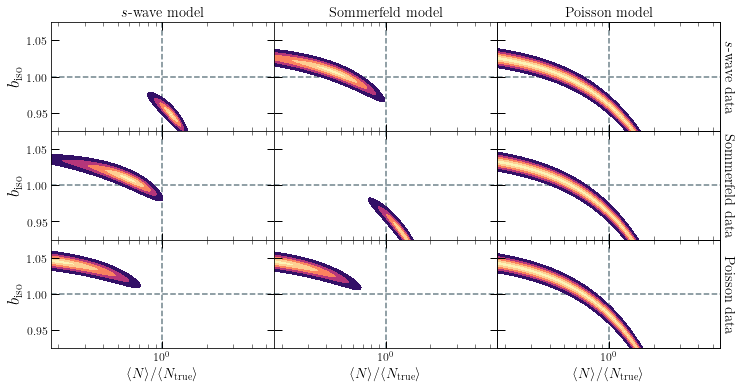

In [14]:
fig, axss = plt.subplots(ncols=3, nrows=3, figsize=(12, 6), sharey=True, sharex=True, gridspec_kw={'wspace': 0, 'hspace': 0})
i = 0
lw = 5
zorder = 1

from matplotlib import cm
cmap = cm.magma_r
axs = axss[0]
levels = [0, 1/2, 4/2, 9/2, 16/2, 25/2]

for i in range(3):
    for ax, s, lab in zip(axss[i], SS[i], ['s-wave L', 'som L', 'poisson L']):
        colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
        
        for expdat, expo in zip(s, exposure_search):
            indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
#             ax.contourf(fwimps / p['fwimp'], begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
            con = ax.contourf(fwimps / p['fwimp'], begs, (0.5*(expdat - expdat.min())), cmap=cmap, levels=levels)
            print([0.5 * expdat.min() - 4, 0.5 * expdat.min() - 1])
            print(con.levels)
            ax.axvline(p['fwimp'] / p['fwimp'], ls='--', color='xkcd:steel gray', zorder=-100)
            ax.axhline(1, ls='--', color='xkcd:steel gray', zorder=-100)
#             ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)

        ax.set_xscale('log')

for ax in axss[-1]:
#     ax.set_xlabel(r'$f_\mathrm{WIMP}$', fontsize='large')
#     ax.set_xlabel(r'$\Phi_\mathrm{PP}$', fontsize='large')
    ax.set_xlabel(r'$\langle N\rangle/\langle N_\mathrm{true}\rangle$', fontsize='large')
    
axss[0, 0].set_ylabel(r'$b_\mathrm{iso}$', fontsize='x-large')
axss[1, 0].set_ylabel(r'$b_\mathrm{iso}$', fontsize='x-large')
axss[2, 0].set_ylabel(r'$b_\mathrm{iso}$', fontsize='x-large')

ax = axss[0, -1].twinx()
ax.set_ylabel('$s$-wave data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

ax = axss[1, -1].twinx()
ax.set_ylabel('Sommerfeld data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

ax = axss[2, -1].twinx()
ax.set_ylabel('Poisson data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

axss[0, 0].set_title(r'$s$-wave model')
axss[0, 1].set_title('Sommerfeld model')
axss[0, 2].set_title('Poisson model')
    
# axss.flatten()[-1].legend()
#     ax.set_yscale('log')
#     ax.set_ylim(bottom=0, top=10)
print(p['fwimp'])
fig.savefig('./output/plots/llhds_2d_fermiexposure_bgd_overmodel.pdf')

In [15]:
SS = [[],[],[]]

# import pickle
# with open('./output/param_scan.pickle', 'rb') as infile:
#     SS = pickle.load(infile)

p['n'] = 0
SS[0] = likelihood_run_for_model_2d(p, s_psh, s_fluxes, model='s', bgd_undermodel=0.97, load_data_file=s_file)

fwimp_orig = p['fwimp']
# p['fwimp'] *= som_fwimp_rescale
# fwimps *= som_fwimp_rescale

p['n'] = -1
SS[1] = likelihood_run_for_model_2d(p, som_psh, som_fluxes, model='som', bgd_undermodel=0.97, load_data_file=som_file)

# p['fwimp'] /= 1e100
# fwimps /= som_fwimp_rescale

p['n'] = 'Null'
SS[2] = likelihood_run_for_model_2d(p, som_psh, som_fluxes, model='', bgd_undermodel=0.97, load_data_file=poi_file)

# p['fwimp'] = fwimp_orig

import pickle
with open('./output/param_scan_bgd_undermodel.pickle', 'wb') as outfile:
    pickle.dump(SS, outfile)

calculating pc to count = 98.0
psh mean 6.874653864048926e-05
loaded skymap from ./output/nNull_skymap_48061.npy
max counts 98.0 56.0
0 / 80
10 / 80
20 / 80
30 / 80
40 / 80
50 / 80
60 / 80
70 / 80
1 / 1
calculating pc to count = 95.0
psh mean 8.412409206005941e-05
loaded skymap from ./output/n-1_skymap_90168.npy
max counts 95.0 63.0
0 / 80
10 / 80
20 / 80
30 / 80
40 / 80
50 / 80
60 / 80
70 / 80
1 / 1
calculating pc to count = 95.0
psh mean 8.412409206005941e-05
loaded skymap from ./output/nNull_skymap_36658.npy
max counts 95.0 60.0
0 / 80
10 / 80
20 / 80
30 / 80
40 / 80
50 / 80
60 / 80
70 / 80
1 / 1


In [16]:
import pickle
with open('./output/param_scan_bgd_undermodel.pickle', 'rb') as infile:
    SS = pickle.load(infile)
    

[185764.08523655005, 185767.08523655005]
[ 0.   0.5  2.   4.5  8.  12.5]
[185847.98534241618, 185850.98534241618]
[ 0.   0.5  2.   4.5  8.  12.5]
[185792.7244607931, 185795.7244607931]
[ 0.   0.5  2.   4.5  8.  12.5]
[184944.6157549098, 184947.6157549098]
[ 0.   0.5  2.   4.5  8.  12.5]
[184971.428340207, 184974.428340207]
[ 0.   0.5  2.   4.5  8.  12.5]
[184936.27682754333, 184939.27682754333]
[ 0.   0.5  2.   4.5  8.  12.5]
[185579.0798916082, 185582.0798916082]
[ 0.   0.5  2.   4.5  8.  12.5]
[185616.65621866356, 185619.65621866356]
[ 0.   0.5  2.   4.5  8.  12.5]
[185534.63786571307, 185537.63786571307]
[ 0.   0.5  2.   4.5  8.  12.5]
1.78


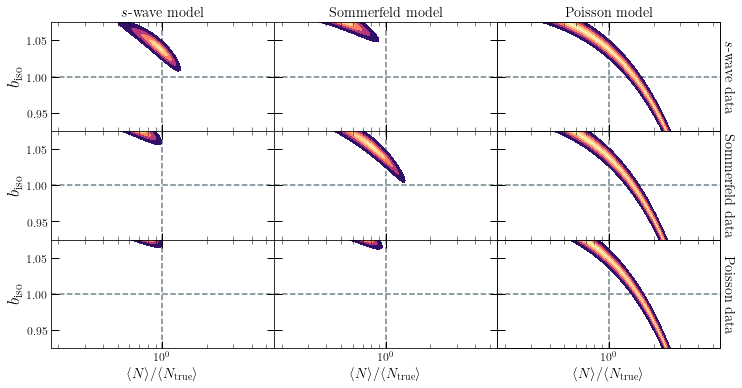

In [17]:
fig, axss = plt.subplots(ncols=3, nrows=3, figsize=(12, 6), sharey=True, sharex=True, gridspec_kw={'wspace': 0, 'hspace': 0})
i = 0
lw = 5
zorder = 1

from matplotlib import cm
cmap = cm.magma_r
axs = axss[0]
levels = [0, 1/2, 4/2, 9/2, 16/2, 25/2]

for i in range(3):
    for ax, s, lab in zip(axss[i], SS[i], ['s-wave L', 'som L', 'poisson L']):
        colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
        
        for expdat, expo in zip(s, exposure_search):
            indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
#             ax.contourf(fwimps / p['fwimp'], begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
            con = ax.contourf(fwimps / p['fwimp'], begs, (0.5*(expdat - expdat.min())), cmap=cmap, levels=levels)
            print([0.5 * expdat.min() - 4, 0.5 * expdat.min() - 1])
            print(con.levels)
            ax.axvline(p['fwimp'] / p['fwimp'], ls='--', color='xkcd:steel gray', zorder=-100)
            ax.axhline(1, ls='--', color='xkcd:steel gray', zorder=-100)
#             ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)

        ax.set_xscale('log')

for ax in axss[-1]:
#     ax.set_xlabel(r'$f_\mathrm{WIMP}$', fontsize='large')
#     ax.set_xlabel(r'$\Phi_\mathrm{PP}$', fontsize='large')
    ax.set_xlabel(r'$\langle N\rangle/\langle N_\mathrm{true}\rangle$', fontsize='large')
    
axss[0, 0].set_ylabel(r'$b_\mathrm{iso}$', fontsize='x-large')
axss[1, 0].set_ylabel(r'$b_\mathrm{iso}$', fontsize='x-large')
axss[2, 0].set_ylabel(r'$b_\mathrm{iso}$', fontsize='x-large')

ax = axss[0, -1].twinx()
ax.set_ylabel('$s$-wave data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

ax = axss[1, -1].twinx()
ax.set_ylabel('Sommerfeld data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

ax = axss[2, -1].twinx()
ax.set_ylabel('Poisson data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

axss[0, 0].set_title(r'$s$-wave model')
axss[0, 1].set_title('Sommerfeld model')
axss[0, 2].set_title('Poisson model')
    
# axss.flatten()[-1].legend()
#     ax.set_yscale('log')
#     ax.set_ylim(bottom=0, top=10)
print(p['fwimp'])
fig.savefig('./output/plots/llhds_2d_fermiexposure_bgd_undermodel.pdf')

Add:
- Float beg but fix bg to 0.97
- Float beg w/ same bg
- Generate w/ no DM signal and fit s/som/poi (null test)
- Add to overleaf
- 

In [18]:
# fig, axs = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

# ax = axs[0]
# s_S, som_S, poisson_S = SS[0]
# max_swave = np.amin(s_S)
# max_som = np.amin(som_S)
# max_poi = np.amin(poisson_S)
# ax.plot(exposure_search, -max_swave + max_som, ls='', marker='*', color='xkcd:royal purple', label=r'$\mathcal{S}_{min}^{som} - \mathcal{S}_{min}^{s}$')
# ax.plot(exposure_search, -max_swave + max_poi, ls='', marker='*', color='xkcd:terra cotta', label=r'$\mathcal{S}_{min}^{poi} - \mathcal{S}_{min}^{s}$')
# # ax.plot(exposure_search, max_som - max_poi, ls='', marker='*', color='xkcd:pink', label=r'$\mathcal{S}_{min}^{som} - \mathcal{S}_{min}^{poi}$')
# ax.set_xscale('symlog')
# ax.set_yscale('symlog')
# ax.grid()
# # ax.set_ylim(bottom=10)
# ax.set_ylabel(r'$\Delta\mathcal{S}_{min}$', fontsize='x-large')
# ax.set_xlabel(r'Exposure', fontsize='x-large')
# ax.legend()
 
# ax = axs[1]
# s_S, som_S, poisson_S = SS[1]
# max_swave = np.amin(s_S)
# max_som = np.amin(som_S)
# max_poi = np.amin(poisson_S)
# ax.plot(exposure_search, max_swave - max_som, ls='', marker='*', color='xkcd:royal purple', label=r'$\mathcal{S}_{min}^{s} - \mathcal{S}_{min}^{som}$')
# # ax.plot(exposure_search, max_swave - max_poi, ls='', marker='*', color='xkcd:terra cotta', label=r'$\mathcal{S}_{min}^{s} - \mathcal{S}_{min}^{poi}$')
# ax.plot(exposure_search, - max_som + max_poi, ls='', marker='*', color='xkcd:pink', label=r'$\mathcal{S}_{min}^{poi} - \mathcal{S}_{min}^{som}$')
# ax.set_xscale('symlog')
# ax.set_yscale('symlog')
# ax.grid()
# # ax.set_ylim(bottom=10)
# ax.set_ylabel(r'$\Delta\mathcal{S}_{min}$', fontsize='x-large')
# ax.set_xlabel(r'Exposure', fontsize='x-large')
# ax.legend()
# print(max_poi - max_som)
# axs[0].set_title('s-wave data')
# axs[1].set_title('som data')

# fig.savefig('./output/deltaS_2d.pdf')

NameError: name 'mean' is not defined

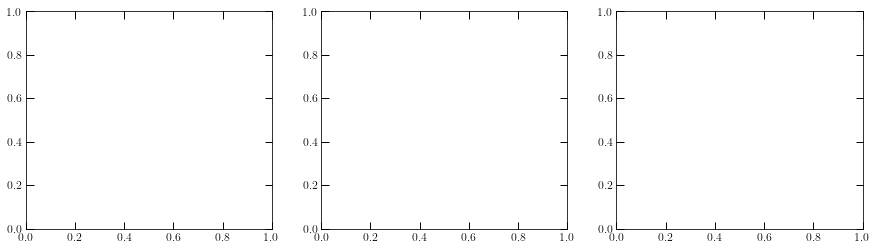

In [19]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
axs[0].plot(exposure_search, mean, label='mean', marker='o', ms=10)
axs[0].set_title('mean counts')
axs[1].plot(exposure_search, meanpc, label='P(C) mean', marker='o', ms=10)
axs[1].set_title('mean P(C)')
axs[2].plot(exposure_search, total, label='P(C) mean', marker='o', ms=10)
axs[2].set_title('total counts')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_ylim(bottom=0, top=)
ax.set_yscale('log')
ax.set_ylabel('Exposure [cm2 s]')
ax.set_xscale('log')
ax.set_xlabel('fwimp')
pc = ax.pcolormesh(fwimps, exposure_search, np.log10(s_S), cmap=cm.jet, shading='auto')
fig.colorbar(pc, label='S for s-wave');

In [ ]:
max_swave = np.amin(s_S, axis=-1)
max_som = np.amin(som_S, axis=-1)
max_poi = np.amin(poisson_S, axis=-1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, (ax_som,ax_s, ax_p, ax_d) = plt.subplots(nrows=4, sharex=True, figsize=(5,15))
# fig, (ax_som, ax_s, ax_p, ax_d) p
xs = np.linspace(0, 20)
ys = xs**2
ax_s.plot(xs, ys)
ax_p.plot(xs, ys)
ax_d.plot(xs, ys)
ax_som.plot(xs, ys)
# ax_som.plot(xs, ys)
# ax_som.plot(xs, ys)
# ax_som.plot(xs, ys * 1.5, color='green', label='green')
# ax_som.set_ylabel('Somerfeld J factor')